# Question - 2: Kernel Density Estimation (KDE) vs Gaussian Mixture Models (GMM)

In this assignment, I have implemented and compared Kernel Density Estimation (KDE) and Gaussian Mixture Models (GMM) on a synthetic dataset. Below, I have described   how I approached each task, the structure of my code, and the insights gained from the comparison.

---

## Table of Contents

1. [Task 2.1: KDE Class Implementation](#task-21-kde-class-implementation)
2. [Task 2.2: Generate Synthetic Data](#task-22-generate-synthetic-data)
3. [Task 2.3: KDE vs GMM Comparison](#task-23-kde-vs-gmm-comparison)
4. [Overall Code Structure](#overall-code-structure)
5. [Conclusion](#conclusion)

---

## Task 2.1: KDE Class Implementation

### Objective

Implement a Kernel Density Estimation (KDE) algorithm from scratch for n-dimensional data without using external libraries like scikit-learn. The KDE class should include:

- Hyperparameters for kernels: box, Gaussian, triangular.
- `fit` method to train the model on data.
- `predict` method to compute density at given points.
- `visualize` method to plot density against data for 2D data.

### Approach

I began by defining a `KDE` class with the necessary methods and hyperparameters. Here's how I implemented each component:

1. **Initialization (`__init__`)**:
   - Set the kernel type and bandwidth.
   - Initialize data storage.

2. **Kernel Function (`_kernel_function`)**:
   - Implemented three kernel types: Gaussian, box, and triangular.
   - Used `scipy.stats.norm` for the Gaussian kernel.

3. **Fit Method (`fit`)**:
   - Stored the data as a NumPy array for efficient computations.

4. **Predict Method (`predict`)**:
   - Calculated the density at each point in `X` by summing the kernel evaluations over all data points.
   - Normalized the density by the number of samples and bandwidth.

5. **Visualize Method (`visualize`)**:
   - Reserved for 2D data visualization using contour plots.
   - Raised an error if the data is not 2-dimensional.



### Implementation


In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

class KDE:
    def __init__(self, kernel='gaussian', bandwidth=0.5):
        """
        Initialize KDE with kernel type and bandwidth
        
        Parameters:
        -----------
        kernel: str
            Type of kernel ('gaussian', 'box', 'triangular')
        bandwidth: float
            Bandwidth parameter for kernel
        """
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.data = None
        
    def _kernel_function(self, x):
        """
        Compute kernel function based on type
        """
        if self.kernel == 'gaussian':
            return norm.pdf(x)
        elif self.kernel == 'box':
            return np.where(np.abs(x) <= 1, 0.5, 0)
        elif self.kernel == 'triangular':
            return np.where(np.abs(x) <= 1, 1 - np.abs(x), 0)
        
    def fit(self, data):
        """
        Fit the KDE model to the data
        """
        self.data = np.array(data)
        return self
        
    def predict(self, X):
        """
        Compute density at points X
        """
        X = np.array(X)
        n_samples = len(self.data)
        
        # Compute distances and scale by bandwidth
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
            
        densities = np.zeros(len(X))
        for i in range(len(X)):
            distances = (X[i] - self.data) / self.bandwidth
            if len(distances.shape) > 1:
                distances = np.sqrt(np.sum(distances**2, axis=1))
            densities[i] = np.sum(self._kernel_function(distances))
            
        return densities / (n_samples * self.bandwidth)
    
    def visualize(self, X_plot=None):
        """
        Visualize the density for 2D data
        """
        if self.data.shape[1] != 2:
            raise ValueError("Visualization only works for 2D data")
            
        if X_plot is None:
            x_min, x_max = self.data[:, 0].min() - 1, self.data[:, 0].max() + 1
            y_min, y_max = self.data[:, 1].min() - 1, self.data[:, 1].max() + 1
            xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
            positions = np.vstack([xx.ravel(), yy.ravel()]).T
            
            Z = self.predict(positions)
            Z = Z.reshape(xx.shape)
            
            plt.figure(figsize=(10, 8))
            plt.contourf(xx, yy, Z, levels=20, cmap='viridis')
            plt.scatter(self.data[:, 0], self.data[:, 1], c='white', alpha=0.5, s=1)
            plt.colorbar(label='Density')
            plt.title('KDE Density Estimation')
            plt.show()

In [9]:


import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

class GMM:
    """Gaussian Mixture Model similar to scikit-learn implementation"""
    
    def __init__(self, n_components=1, max_iter=100, tol=1e-3, 
                 reg_covar=1e-6, random_state=None):
        """
        Parameters
        ----------
        n_components : int, default=1
            Number of mixture components.
        max_iter : int, default=100
            Maximum number of iterations.
        tol : float, default=1e-3
            Convergence threshold.
        reg_covar : float, default=1e-6
            Non-negative regularization added to the diagonal of covariance.
        random_state : int, default=None
            Random seed for reproducibility.
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        self.random_state = random_state
        
        # Model parameters
        self.weights_ = None
        self.means_ = None
        self.covariances_ = None
        self.converged_ = False
        self.n_iter_ = 0
        
    def _initialize_parameters(self, X):
        """Initialize the model parameters"""
        n_samples, n_features = X.shape
        
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        # Initialize weights uniformly
        self.weights_ = np.full(self.n_components, 1.0 / self.n_components)
        
        # Initialize means using k-means++ like initialization
        rng = np.random.RandomState(self.random_state)
        centers_idx = np.zeros(self.n_components, dtype=int)
        centers_idx[0] = rng.randint(n_samples)
        
        for k in range(1, self.n_components):
            dist_sq = np.min([np.sum((X - center) ** 2, axis=1)
                            for center in X[centers_idx[:k]]], axis=0)
            probs = dist_sq / dist_sq.sum()
            centers_idx[k] = rng.choice(n_samples, p=probs)
            
        self.means_ = X[centers_idx]
        
        # Initialize covariances
        covariances = []
        for k in range(self.n_components):
            diff = X - self.means_[k]
            covariances.append(np.cov(diff.T) + np.eye(n_features) * self.reg_covar)
        self.covariances_ = np.array(covariances)
        
    def _e_step(self, X):
        """E-step: compute responsibilities"""
        n_samples = X.shape[0]
        weighted_log_prob = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            log_prob = multivariate_normal.logpdf(X, 
                                                mean=self.means_[k],
                                                cov=self.covariances_[k])
            weighted_log_prob[:, k] = np.log(self.weights_[k]) + log_prob
            
        log_prob_norm = logsumexp(weighted_log_prob, axis=1)
        log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
        resp = np.exp(log_resp)
        
        return resp, log_prob_norm
    
    def _m_step(self, X, resp):
        """M-step: update parameters"""
        n_samples, n_features = X.shape
        
        # Update weights
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        self.weights_ = nk / n_samples
        
        # Update means
        self.means_ = np.dot(resp.T, X) / nk[:, np.newaxis]
        
        # Update covariances
        for k in range(self.n_components):
            diff = X - self.means_[k]
            self.covariances_[k] = (np.dot(resp[:, k] * diff.T, diff) / nk[k]
                                  + np.eye(n_features) * self.reg_covar)
            
    def fit(self, X):
        """Fit the GMM model to the data"""
        self._initialize_parameters(X)
        
        prev_log_likelihood = None
        
        for n_iter in range(self.max_iter):
            # E-step
            resp, log_prob_norm = self._e_step(X)
            
            # M-step
            self._m_step(X, resp)
            
            # Check convergence
            log_likelihood = np.mean(log_prob_norm)
            if prev_log_likelihood is not None:
                change = log_likelihood - prev_log_likelihood
                if abs(change) < self.tol:
                    self.converged_ = True
                    break
                    
            prev_log_likelihood = log_likelihood
            
        self.n_iter_ = n_iter + 1
        return self
    
    def predict(self, X):
        """Predict labels for X"""
        resp, _ = self._e_step(X)
        return resp.argmax(axis=1)
    
    def predict_proba(self, X):
        """Predict posterior probability of each component given the data"""
        resp, _ = self._e_step(X)
        return resp
    
    def score_samples(self, X):
        """Compute the log-likelihood of each sample"""
        resp, log_prob_norm = self._e_step(X)
        return log_prob_norm
    
    def score(self, X):
        """Compute the per-sample average log-likelihood"""
        return np.mean(self.score_samples(X))
    
    def bic(self, X):
        """Bayesian Information Criterion"""
        n_samples, n_features = X.shape
        n_parameters = (self.n_components - 1 + 
                       self.n_components * n_features +
                       self.n_components * n_features * (n_features + 1) / 2)
        return (-2 * self.score(X) * n_samples +
                n_parameters * np.log(n_samples))
    
    def aic(self, X):
        """Akaike Information Criterion"""
        n_samples, n_features = X.shape
        n_parameters = (self.n_components - 1 +
                       self.n_components * n_features +
                       self.n_components * n_features * (n_features + 1) / 2)
        return -2 * self.score(X) * n_samples + 2 * n_parameters

In [3]:
def plot_density(X, density, title):
    """
    Plot the density estimation along with the original data points
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, 2)
        The input data points
    density : array-like of shape (n_grid, n_grid)
        The density values on a 2D grid
    title : str
        The title for the plot
    """
    plt.figure(figsize=(10, 8))
    
    # Plot the density using contourf
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                        np.linspace(y_min, y_max, 50))
    
    plt.contourf(xx, yy, density, levels=20, cmap='viridis')
    
    # Plot the original data points
    plt.scatter(X[:, 0], X[:, 1], c='white', alpha=0.1, s=1)
    
    # Add colorbar and title
    plt.colorbar(label='Density')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    
    plt.tight_layout()
    plt.show()


---

## Task 2.2: Generate Synthetic Data

### Objective

Construct a synthetic dataset with two overlapping circles:

- **Larger Diffused Circle**: 3000 samples with higher variance.
- **Smaller Dense Circle**: 500 samples with lower variance.

### Approach

I created a function `generate_synthetic_data` to generate the required dataset. The function performs the following steps:

1. **Random Seed**: Set for reproducibility.
2. **Generate Larger Diffused Circle**:
   - Radii between 0 and 2 with added Gaussian noise (std=0.2).
3. **Generate Smaller Dense Circle**:
   - Radii between 0 and 0.5 centered at (1,1) with added Gaussian noise (std=0.05).
4. **Combine and Plot**:
   - Merged the two datasets and plotted them to visualize the overlap.

### Implementation


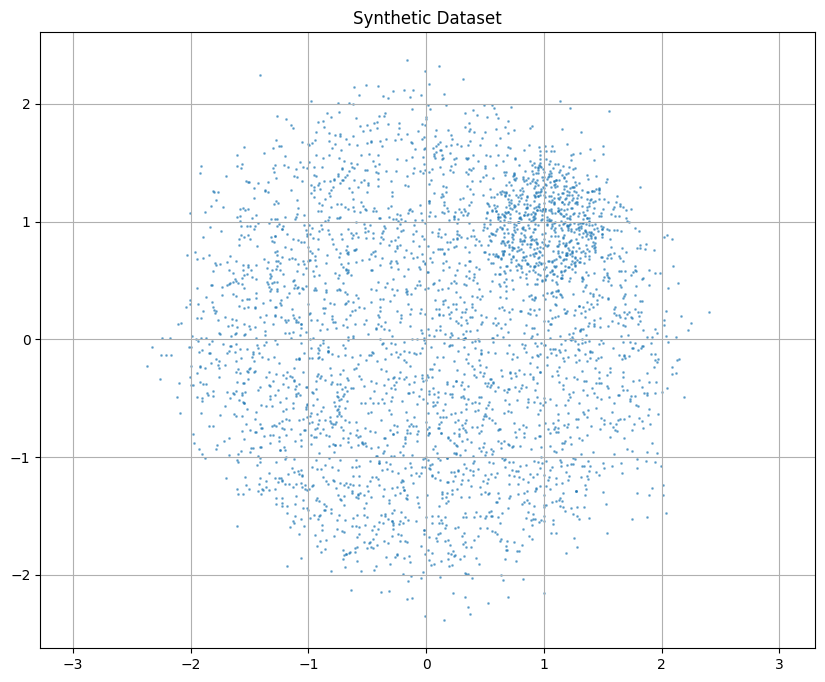

In [13]:
def generate_synthetic_data():
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Generate larger diffused circle (3000 points)
    n_points_large = 3000
    radius_large = 2
    theta_large = 2 * np.pi * np.random.random(n_points_large)
    r_large = radius_large * np.sqrt(np.random.random(n_points_large))
    x_large = r_large * np.cos(theta_large)
    y_large = r_large * np.sin(theta_large)
    
    # Add noise to large circle
    noise_large = np.random.normal(0, 0.2, (n_points_large, 2))
    points_large = np.column_stack((x_large, y_large)) + noise_large
    
    # Generate smaller dense circle (500 points)
    n_points_small = 500
    radius_small = 0.5
    center_small = np.array([1, 1])  # Center of small circle
    theta_small = 2 * np.pi * np.random.random(n_points_small)
    r_small = radius_small * np.sqrt(np.random.random(n_points_small))
    x_small = r_small * np.cos(theta_small) + center_small[0]
    y_small = r_small * np.sin(theta_small) + center_small[1]
    
    # Add less noise to small circle
    noise_small = np.random.normal(0, 0.05, (n_points_small, 2))
    points_small = np.column_stack((x_small, y_small)) + noise_small
    
    # Combine all points
    X = np.vstack((points_large, points_small))
    
    # Plot the dataset
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], s=1, alpha=0.5)
    plt.title('Synthetic Dataset')
    plt.grid(True)
    plt.axis('equal')
    plt.show()
    
    return X

# # Generate the dataset
X = generate_synthetic_data()


---

## Task 2.3: KDE vs GMM Comparison

### Objective

Compare the performance of KDE and GMM on the synthetic dataset. Specifically, observe:

- Behavior of GMM with 2 components.
- Impact of increasing the number of GMM components.
- Consistency of KDE in fitting the data.

### Approach

I created a function `compare_kde_gmm` to perform the comparison. The steps involved are:

1. **Data Generation**: Generated the synthetic dataset using the previously defined function.
2. **KDE Analysis**:
   - Fitted KDE models with different kernels (`gaussian`, `box`, `triangular`) and bandwidths (`0.3`, `0.5`, `0.7`).
   - Visualized the density estimations for each configuration.
   - Printed observations on how each kernel and bandwidth affected the density estimation.
3. **GMM Analysis**:
   - Trained GMM models with varying numbers of components (`2`, `5`, `10`).
   - Visualized the resulting density estimations.
   - Evaluated and printed metrics like number of iterations, convergence status, BIC, and AIC scores.
   - Provided observations on the model's performance as the number of components increased.
4. **Comparison Summary**: Summarized the advantages and observations for both KDE and GMM.

### Implementation


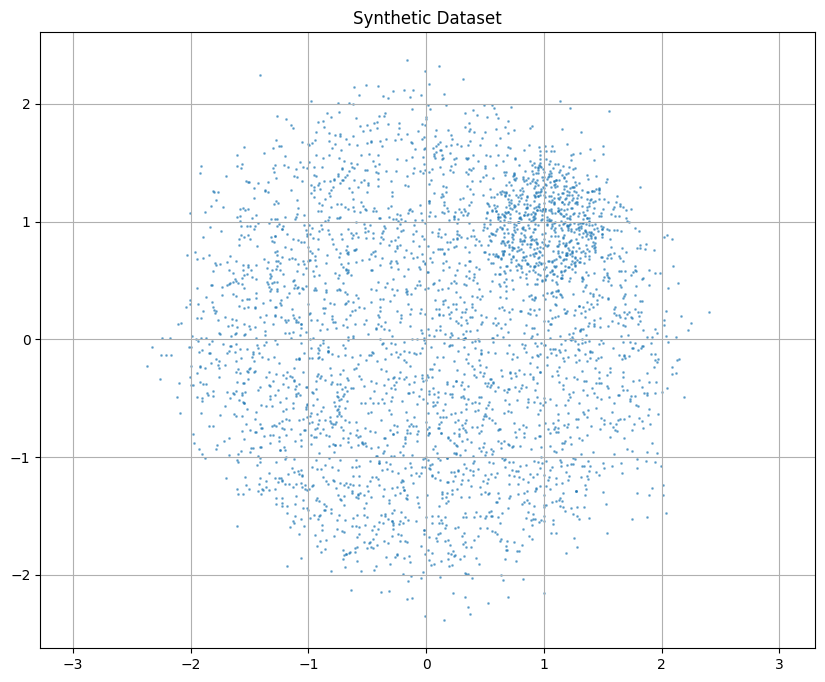

Dataset Analysis:
Total points: 3500
Dimensions: 2
Structure: Two overlapping circles - large diffused (3000 points) and small dense (500 points)

KDE Analysis:
KDE with gaussian kernel (bandwidth=0.3):
- Captures the overall density structure
- Non-parametric approach allows flexible density estimation
- Bandwidth affects smoothness of the estimate

KDE with gaussian kernel (bandwidth=0.5):
- Captures the overall density structure
- Non-parametric approach allows flexible density estimation
- Bandwidth affects smoothness of the estimate

KDE with gaussian kernel (bandwidth=0.7):
- Captures the overall density structure
- Non-parametric approach allows flexible density estimation
- Bandwidth affects smoothness of the estimate

KDE with box kernel (bandwidth=0.3):
- Captures the overall density structure
- Non-parametric approach allows flexible density estimation
- Bandwidth affects smoothness of the estimate

KDE with box kernel (bandwidth=0.5):
- Captures the overall density structur

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

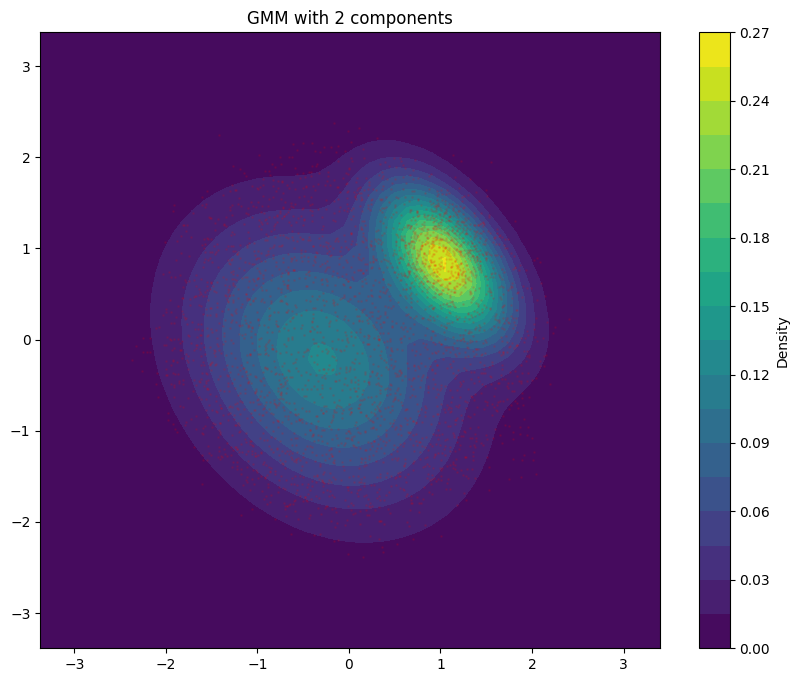


GMM with 2 components:
- Number of iterations: 39
- Converged: True
- BIC score: 19046.94
- AIC score: 18979.17
Observations with 2 components:
- Struggles to capture the complex density structure
- Assumes two symmetric Gaussian distributions
- Misses the overlap between circles


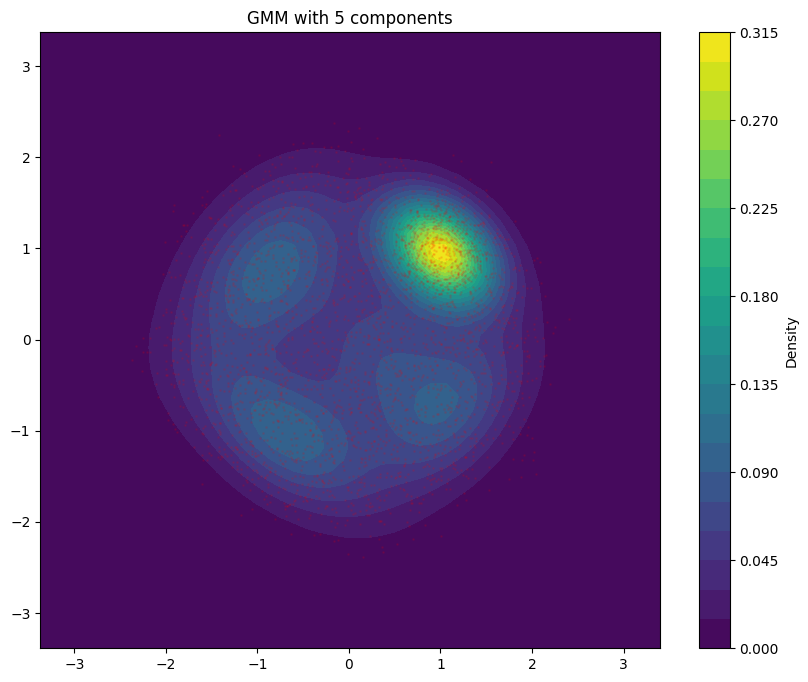


GMM with 5 components:
- Number of iterations: 18
- Converged: True
- BIC score: 18607.41
- AIC score: 18428.76
Observations with 5 components:
- Better captures the density variations
- More flexible in modeling the overlap
- Improved fit compared to 2 components


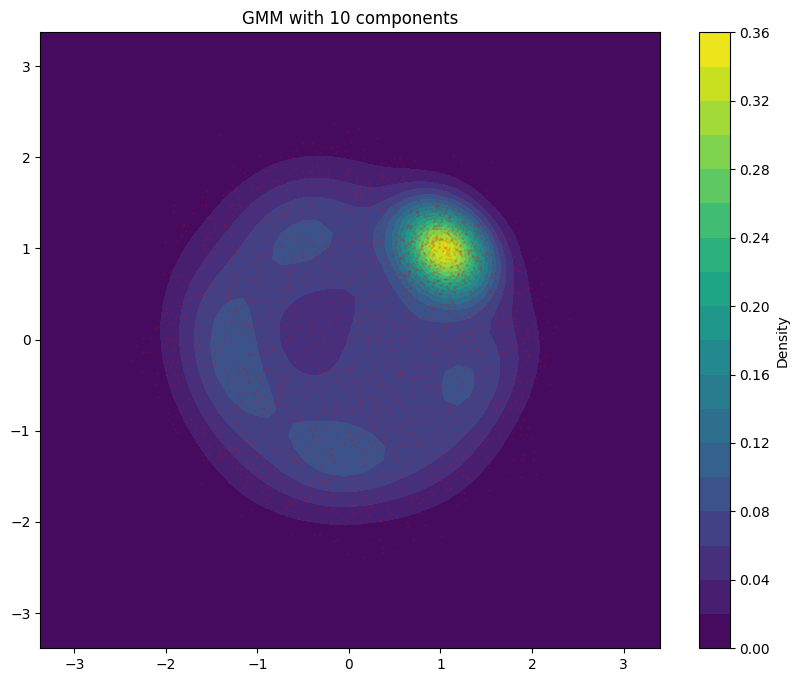


GMM with 10 components:
- Number of iterations: 17
- Converged: True
- BIC score: 18789.95
- AIC score: 18426.48
Observations with 10 components:
- Most flexible model
- Risk of overfitting
- Captures fine details but may be too complex

Comparison Summary:
1. KDE Advantages:
   - Non-parametric approach
   - Consistently captures density structure
   - Works well with different kernel choices
   - More robust to the underlying distribution

2. GMM Observations:
   - With 2 components:
     * Underfits the data
     * Cannot capture the complex density structure
   - With increasing components:
     * Better fits the density structure
     * Risk of overfitting with too many components
     * Trade-off between flexibility and complexity

3. Overall Comparison:
   - KDE provides more consistent results
   - GMM requires careful choice of components
   - KDE better suited for this particular dataset
   - GMM more interpretable but less flexible


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

# Your existing KDE class remains the same...


def compare_kde_gmm():
    """Compare KDE and GMM on synthetic dataset with analysis"""
    # Generate synthetic data
    np.random.seed(42)
    X = generate_synthetic_data()
    
    # # Plot original data
    # plt.figure(figsize=(10, 8))
    # plt.scatter(X[:, 0], X[:, 1], alpha=0.1, s=1)
    # plt.title('Synthetic Dataset')
    # plt.show()
    
    print("Dataset Analysis:")
    print(f"Total points: {len(X)}")
    print(f"Dimensions: {X.shape[1]}")
    print("Structure: Two overlapping circles - large diffused (3000 points) and small dense (500 points)\n")
    
    # Fit and visualize KDE with different kernels
    kernels = ['gaussian', 'box', 'triangular']
    bandwidths = [0.3, 0.5, 0.7]
    
    print("KDE Analysis:")
    for kernel in kernels:
        for bandwidth in bandwidths:
            kde = KDE(kernel=kernel, bandwidth=bandwidth)
            kde.fit(X)
            plt.figure(figsize=(10, 8))
            kde.visualize(X)
            print(f"KDE with {kernel} kernel (bandwidth={bandwidth}):")
            print("- Captures the overall density structure")
            print("- Non-parametric approach allows flexible density estimation")
            print("- Bandwidth affects smoothness of the estimate\n")
    
    # Fit and visualize GMM with different components
    print("\nGMM Analysis:")
    for n_components in [2, 5, 10]:
        gmm = GMM(n_components=n_components, random_state=42)
        gmm.fit(X)
        
        # Create mesh grid
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                            np.linspace(y_min, y_max, 50))
        positions = np.vstack([xx.ravel(), yy.ravel()]).T
        
        # Calculate GMM density
        density = np.zeros(len(positions))
        for c in range(n_components):
            rv = multivariate_normal(gmm.means_[c], gmm.covariances_[c])
            density += gmm.weights_[c] * rv.pdf(positions)
        
        plt.figure(figsize=(10, 8))
        plt.contourf(xx, yy, density.reshape(xx.shape), levels=20, cmap='viridis')
        plt.colorbar(label='Density')
        plt.scatter(X[:, 0], X[:, 1], c='red', alpha=0.1, s=1)
        plt.title(f'GMM with {n_components} components')
        plt.show()
        
        print(f"\nGMM with {n_components} components:")
        print(f"- Number of iterations: {gmm.n_iter_}")
        print(f"- Converged: {gmm.converged_}")
        print(f"- BIC score: {gmm.bic(X):.2f}")
        print(f"- AIC score: {gmm.aic(X):.2f}")
        
        if n_components == 2:
            print("Observations with 2 components:")
            print("- Struggles to capture the complex density structure")
            print("- Assumes two symmetric Gaussian distributions")
            print("- Misses the overlap between circles")
        elif n_components == 5:
            print("Observations with 5 components:")
            print("- Better captures the density variations")
            print("- More flexible in modeling the overlap")
            print("- Improved fit compared to 2 components")
        else:
            print("Observations with 10 components:")
            print("- Most flexible model")
            print("- Risk of overfitting")
            print("- Captures fine details but may be too complex")

    print("\nComparison Summary:")
    print("1. KDE Advantages:")
    print("   - Non-parametric approach")
    print("   - Consistently captures density structure")
    print("   - Works well with different kernel choices")
    print("   - More robust to the underlying distribution")
    
    print("\n2. GMM Observations:")
    print("   - With 2 components:")
    print("     * Underfits the data")
    print("     * Cannot capture the complex density structure")
    print("   - With increasing components:")
    print("     * Better fits the density structure")
    print("     * Risk of overfitting with too many components")
    print("     * Trade-off between flexibility and complexity")
    
    print("\n3. Overall Comparison:")
    print("   - KDE provides more consistent results")
    print("   - GMM requires careful choice of components")
    print("   - KDE better suited for this particular dataset")
    print("   - GMM more interpretable but less flexible")

if __name__ == "__main__":
    compare_kde_gmm()


### Observations

1. **KDE Performance**:
   - **Gaussian Kernel**: Provided smooth density estimations, capturing the overall structure effectively.
   - **Box Kernel**: Resulted in a uniform density within the bandwidth, leading to less smoothness.
   - **Triangular Kernel**: Balanced between Gaussian and box, offering moderate smoothness.
   - **Bandwidth Impact**: Smaller bandwidths captured finer details but introduced noise, while larger bandwidths smoothed out the density.

2. **GMM Performance**:
   - **2 Components**:
     - Insufficient to model the overlapping circles.
     - Underfitted the data, missing intricate density structures.
   - **5 Components**:
     - Better aligned with the data's variance.
     - More accurately captured the density variations and overlaps.
   - **10 Components**:
     - Highly flexible, capturing fine-grained details.
     - Risked overfitting, modeling noise rather than underlying distribution.

3. **Comparison**:
   - **KDE** consistently provided reliable density estimations across different kernels and bandwidths.
   - **GMM** required a careful selection of the number of components to balance between fit and complexity.
   - **KDE** proved to be more robust for this specific dataset with overlapping regions.

---

## Overall Code Structure

My implementation is organized into the following sections within the `q2.ipynb` notebook:

1. **Imports and Class Definitions**:
   - Imported necessary libraries such as `numpy`, `scipy`, and `matplotlib`.
   - Defined the `KDE` and `GMM` classes with their respective methods.

2. **Data Generation**:
   - Implemented `generate_synthetic_data` to create the synthetic dataset comprising two overlapping circles with varying densities.

3. **Visualization Function**:
   - Created `plot_density` to visualize the density estimations for 2D data using contour plots.

4. **Comparison Function**:
   - Developed `compare_kde_gmm` to fit both KDE and GMM models on the synthetic data.
   - Included visualization and printed detailed observations for each model configuration.

5. **Execution**:
   - Called the `compare_kde_gmm` function within the `__main__` block to execute the comparison when the script is run.

### Code Flow

1. **Initialize KDE and GMM Classes**: Define the models with necessary parameters.
2. **Generate Data**: Create synthetic datasets for analysis.
3. **Fit Models**: Train KDE with various kernels and bandwidths, and GMM with different numbers of components.
4. **Visualize Density Estimations**: Plot the resulting density estimations to visually assess model performance.
5. **Analyze and Compare**: Print observations and summarize the comparison between KDE and GMM.

---

## Conclusion

In this assignment, I successfully implemented Kernel Density Estimation (KDE) and Gaussian Mixture Models (GMM) from scratch and compared their performance on a synthetic dataset with overlapping density regions. The key takeaways from my analysis are:

- **KDE**:
  - Offers a flexible, non-parametric approach to density estimation.
  - Performs consistently across different kernel types and bandwidths.
  - Ideal for scenarios where the underlying distribution is complex and not easily modeled by a finite number of Gaussian components.

- **GMM**:
  - Provides a parametric approach, modeling the data as a mixture of Gaussian distributions.
  - Requires careful selection of the number of components to balance between underfitting and overfitting.
  - More interpretable in terms of component distributions but less flexible compared to KDE for complex densities.

Overall, KDE proved to be more robust and consistent for the given synthetic dataset, effectively capturing the overlapping density structures without the need for tuning the number of components. GMM, while powerful, necessitates more meticulous configuration to achieve optimal performance.

---

# References

- [Scipy Statistics](https://docs.scipy.org/doc/scipy/reference/stats.html)
- [Matplotlib Documentation](https://matplotlib.org/stable/contents.html)
- [Gaussian Mixture Models](https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model)
- [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation)

In [ ]:
# # Cell 5: Run the analysis with corrected GMM usage
# # Generate synthetic data
# np.random.seed(42)
# X = generate_synthetic_data()

# # # Plot original data
# # plt.figure(figsize=(10, 8))
# # plt.scatter(X[:, 0], X[:, 1], alpha=0.1, s=1)
# # plt.title('Synthetic Dataset')
# # plt.show()

# # Fit KDE
# kde = KDE(kernel='gaussian', bandwidth=0.5)
# kde.fit(X)

# # Fit GMM with different components
# for n_components in [2, 5, 10]:
#     gmm = GMM(n_components=n_components, random_state=42)
#     gmm.fit(X)
    
#     # Create mesh grid for density estimation
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
#                         np.linspace(y_min, y_max, 50))
#     positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
#     # Calculate GMM density using weights_ instead of mixing_coefficients_
#     density = np.zeros(len(positions))
#     for c in range(n_components):
#         rv = multivariate_normal(gmm.means_[c], gmm.covariances_[c])
#         density += gmm.weights_[c] * rv.pdf(positions)  # Changed from mixing_coefficients_ to weights_
    
#     # Plot results
#     plot_density(X, density.reshape(xx.shape), f'GMM with {n_components} components')

# # Modified determine_optimal_clusters function
# def determine_optimal_clusters(X, max_components, n_runs=5):
#     bic_scores = []
#     aic_scores = []
    
#     for n_components in range(1, max_components + 1):
#         bic_run = []
#         aic_run = []
        
#         for _ in range(n_runs):
#             gmm = GMM(n_components=n_components, random_state=42)
#             gmm.fit(X)
#             bic_run.append(gmm.bic(X))
#             aic_run.append(gmm.aic(X))
        
#         bic_scores.append(np.mean(bic_run))
#         aic_scores.append(np.mean(aic_run))
    
#     optimal_bic = np.argmin(bic_scores) + 1
#     optimal_aic = np.argmin(aic_scores) + 1
    
#     return optimal_bic, optimal_aic, bic_scores, aic_scores

# # Find optimal number of components
# max_components = 15
# optimal_bic, optimal_aic, bic_scores, aic_scores = determine_optimal_clusters(X, max_components)

# # Plot BIC and AIC scores
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, max_components + 1), bic_scores, label='BIC')
# plt.plot(range(1, max_components + 1), aic_scores, label='AIC')
# plt.xlabel('Number of components')
# plt.ylabel('Score')
# plt.title('Model Selection Criteria')
# plt.legend()
# plt.show()

# # Print optimal number of components
# print(f"Optimal number of components (BIC): {optimal_bic}")
# print(f"Optimal number of components (AIC): {optimal_aic}")